# COMP5329 - Deep Learning - Assignment 2 - StudentID : 540309652

## Import librairies

In [1]:
import os
import re

import csv

from PIL import Image
from io import StringIO

import statistics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
from torchvision import models
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from tqdm import tqdm
import time

import requests

# pip install transformers datasets evaluate accelerate if you don't have them
from transformers import CLIPProcessor, CLIPModel, ViTImageProcessor, ViTForImageClassification

/home/reynardo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

We are using GPU.


## Load Dataset

In [3]:
os.getcwd()

'/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/COMP4329_Assignment_2'

In [4]:
# to change depending on where you stored the dataset
DIR = './dataset/'

TRAIN_CSV = os.path.join(DIR, "train.csv")
TEST_CSV = os.path.join(DIR, "test.csv")
IMAGES_DIR = os.path.join(DIR, "data")

In [5]:
class MultiLabelDataset(Dataset):
	'''
	The Dataset Class, child of torch.utils.data.Dataset.

	Attributes:
	csv_file (str): A string representation of the file directory to the csv data file.
	image_dir (str): A string representation of the file directory to the images data file.
	'''

	def __init__(self, csv_file, image_dir, transform=None, target_transform=None, has_labels = True):
		self.image_dir = image_dir
		self.transform = transform
		self.target_transform = target_transform
		self.has_labels = has_labels

		with open(csv_file) as file:
			lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
			self.dataframe = pd.read_csv(StringIO(''.join(lines)), escapechar="/")


	def __len__(self):
		'''
		Returns the length of the dataframe representation of the csv component of the dataset.
		'''
		return self.dataframe.shape[0]

	def __getitem__(self, idx):
		'''
		Reads the data from the dataframe then outputs the observation's image tensor, OHE label tensor (if there are labels present), ImageID string and caption string in a tuple form.
	  '''

		if torch.is_tensor(idx):
			idx = idx.tolist()

		img_path = os.path.join(self.image_dir,
								self.dataframe.iloc[idx, self.dataframe.columns.get_loc('ImageID')])

		img = Image.open(img_path).convert("RGB")

		img_id = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('ImageID')]
		caption = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('Caption')]

		if self.has_labels:
			labels = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('Labels')]
			labels = labels.split(' ') # converts the string into an iterable Python list
			labels = [int(x) for x in labels]
			if self.target_transform:
				labels = self.target_transform(labels)
			if self.transform:
				img = self.transform(img)

			sample = (img, labels, img_id, caption)

		else:
			if self.transform:
				img = self.transform(img)
			sample = (img, img_id, caption)

		return sample

## Create train/test/validation set (dataloaders)

In [6]:
# Concluded 19 labels - one-hot encoded. Leaving label 12 in there as it'll just have zeros for this index
NUM_LABELS = 19
BATCH_SIZE = 50
RESIZE_SIZE = 256
CROP_SIZE = 224 # Seems to be the standard image size used (224)
TRAIN_VAL_PROP = 0.8
SEED = 5329

transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), #ImageNet stats
	transforms.Resize(RESIZE_SIZE),
	transforms.RandomHorizontalFlip(),
	transforms.RandomVerticalFlip(),
	transforms.RandomCrop(CROP_SIZE)
])

# The train/val dataset available with labels
train_all_dataset = MultiLabelDataset(csv_file = TRAIN_CSV,
							image_dir = IMAGES_DIR,
							transform = transform,
							target_transform = transforms.Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
							has_labels = True
							)

# Need to further split it up
train_dataset, val_dataset = random_split(train_all_dataset,
										  [int(round(TRAIN_VAL_PROP * len(train_all_dataset))), int(round((1 - TRAIN_VAL_PROP) * len(train_all_dataset)))],
										  generator=torch.Generator().manual_seed(SEED)) # Setting seed to ensure consistency

# The final test dataset with no labels
test_dataset = MultiLabelDataset(csv_file = TEST_CSV,
								 image_dir = IMAGES_DIR,
								transform = transform,
								 has_labels = False)

train_all_dataloader = DataLoader(train_all_dataset, batch_size = BATCH_SIZE, shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 4788, 14713, 14958, 29878 can't be read ?

In [7]:
# Just a cell to see what were the missing rows (because length is 29996)

# Batch_size has to be 1 to run this cell
# i = 0
# for _, _, img_id, _ in tqdm(train_all_dataloader):
#     if int(img_id[0][0:-4])!=i:
#         print("False: ", int(img_id[0][0:-4]), i)
#         i = i+1
#     i += 1

# 4788, 14713, 14958, 29878 can't be read ?

## Show samples

img_ids:  ('1616.jpg', '23056.jpg', '12532.jpg', '22099.jpg', '6011.jpg', '8886.jpg')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


captions:  ('A women who is brushing her teeth while wearing a towel.', 'A motorcycle driving behind a bus next to a driveway.', 'A group of people that are standing near a pole.', 'A person that is brushing his teeth in a bathroom.', 'A group of bicycle that are standing in the sand.', 'A man running across the top of a tennis court.')
Labels : tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]],
       dtype=torch.uint8)


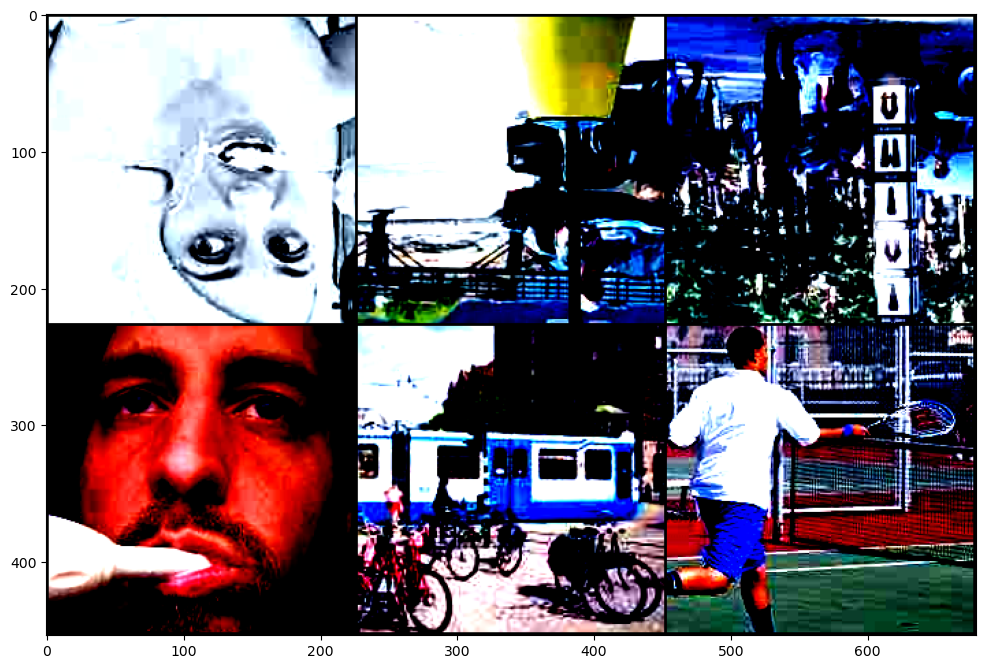

In [8]:
def show_img():
	'''
	A function to show a 2 x 3 plot of 6 random images and display the one-hot encoded labels above it.

	Parameters:
	dataset (AssignmentDataset): The dataset containing the desired set of images for which samples are to be plotted.

	Returns:
	None
	'''

	loader = DataLoader(train_dataset, batch_size = 6, shuffle = True)
	batch = next(iter(loader))
	images, labels, img_ids, captions = batch

	grid = torchvision.utils.make_grid(images, nrow = 3)
	plt.figure(figsize = (12, 12))

	print("img_ids: ", img_ids)
	plt.imshow(np.transpose(grid, (1,2,0)))
	print("captions: ", captions)
	print("Labels :", labels)

show_img()

## CV with CNN

### Custom Models

In [9]:
class AlexNet_Reduced(nn.Module):

	def __init__(self, num_classes=19, stem_stride=4):
		# invoke super class initialisation method
		super(AlexNet_Reduced, self).__init__()

		# define the CNN:
		# 1. define feature extraction layers
		self.features = nn.Sequential(
			# conv-relu-pooling
			nn.Conv2d(3, 2, kernel_size=11, stride=stem_stride, padding=2),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=3, stride=2),
			# conv-relu-pooling
			# nn.Conv2d(64, 256, kernel_size=5, padding=2),
			# nn.ReLU(inplace=True),
			# nn.MaxPool2d(kernel_size=3, stride=2),
			# conv-relu-conv-relu-conv-relu-pooling
			# nn.Conv2d(192, 384, kernel_size=3, padding=1),
			# nn.ReLU(inplace=True),
			# nn.Conv2d(384, 256, kernel_size=3, padding=1),
			# nn.ReLU(inplace=True),
			nn.Conv2d(2, 4, kernel_size=3, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=3, stride=2),
		)
		# 2. define average pooling layer
		self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
		# 3. define fully connected layers
		self.classifier = nn.Sequential(
			nn.Dropout(),                   # use dropout
			nn.Linear(4 * 6 * 6, 8),
			nn.ReLU(inplace=True),
			# nn.Dropout(),                   # use dropout
			# nn.Linear(4096, 4096),
			# nn.ReLU(inplace=True),
			nn.Linear(8, num_classes),
			nn.Sigmoid()
		)

	# define forward-propagation
	def forward(self, x):
		# feature extraction
		x = self.features(x)
		# adaptive pooling
		x = self.avgpool(x)
		# flat the feature map
		x = torch.flatten(x, 1)
		# classification
		x = self.classifier(x)
		return x

	# back-propagation is handled by PyTorch

In [10]:
class CustomCNN(nn.Module):
	def __init__(self, num_classes=19):  # Default to 19 classes unless specified otherwise
		super(CustomCNN, self).__init__()
		self.features = nn.Sequential(
			nn.Conv2d(3, 32, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2, 2),
			nn.Conv2d(32, 64, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2, 2),
			nn.Conv2d(64, 128, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d((9, 9))
		)
		self.classifier = nn.Sequential(
			nn.Linear(128 * 6 * 6, 512),  # Adjust the input features according to the output of the last conv layer
			nn.ReLU(),
			nn.Dropout(0.5),
			nn.Linear(512, num_classes),  # Set the number of output features to match the number of classes
			nn.Sigmoid()
		)

	def forward(self, x):
		x = self.features(x)
		x = torch.flatten(x, 1)  # Flatten the output from the convolutional layers
		x = self.classifier(x)
		return x

### Pretrained Models

In [11]:
def initialize_googlenet_pretrained_model(num_labels):
	model = models.googlenet(weights='DEFAULT')
	num_features = model.fc.in_features
	model.fc = nn.Sequential(
		nn.Linear(num_features, num_labels),
		nn.Sigmoid()
	)
	print(model.fc)
	return model

In [12]:
def initialize_squeezenet_pretrained_model(num_labels):
	model = models.squeezenet1_1(weights='DEFAULT')
	model.classifier[1] = nn.Conv2d(model.classifier[1].in_channels, num_labels, kernel_size=(1, 1), stride=(1, 1))
	model.classifier.add_module('4', nn.Sigmoid())
	return model

### Train and Test Loops

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
	# Set the model to training mode - important for batch normalization and dropout layers
	model.train()
	losses = []
	for inputs, labels, _, _ in tqdm(dataloader, desc="Training: "):

		# if batch_idx > 10: # to test on smaller datasets
		#      break
		
		if (torch.cuda.is_available()):
			inputs = inputs.to('cuda')
			labels = labels.to('cuda')

		# clear gradients of parameters optimized by the optimizer (because PyTorch accumulates gradients)
		optimizer.zero_grad()
		# Compute prediction and loss
		outputs = model(inputs)
		loss = loss_fn(outputs, labels.float())
		losses.append(loss.item())
		# Backpropagation
		loss.backward()
		optimizer.step()
		# if batch_idx % 10 == 0:
		#     print(loss.item())
		
	return np.mean(losses)
		

def validate_loop(dataloader, model, threshold=0.5):
	model.eval()
	accuracies, f1_scores = [], []
	with torch.no_grad():
		for input, label, _, _ in tqdm(dataloader, desc="Validating: "):

			# if idx > 10: # to test on smaller datasets
			#     break

			if (torch.cuda.is_available()):
				input = input.to('cuda')
				label = label.to('cuda')
			
			output = model(input)
			predicted_label = (output > threshold).float()

			predicted_label_numpy = torch.Tensor.numpy(predicted_label.cpu())[0]
			label_numpy = torch.Tensor.numpy(label.cpu())[0]
			accuracies.append(accuracy_score(predicted_label_numpy, label_numpy))
			f1_scores.append(f1_score(predicted_label_numpy, label_numpy, average='macro', zero_division = 0))

	print("Accuracy:", np.mean(accuracies))    
	print("F1 score:", np.mean(f1_scores))

### Training (train only squeezenet)

Epoch 1


Training:   0%|          | 0/480 [00:00<?, ?it/s]/home/reynardo/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Training: 100%|█████████▉| 479/480 [00:47<00:00, 10.31it/s]/home/reynardo/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Validating: 100%|██████████| 5999/5999 [00:30<00:00, 197.94it/s]


Accuracy: 0.9467367368245585
F1 score: 0.8059029883917761
Epoch 2


Validating: 100%|██████████| 5999/5999 [00:34<00:00, 174.20it/s]


Accuracy: 0.946727963432502
F1 score: 0.8058728246343244
Epoch 3


Validating: 100%|██████████| 5999/5999 [00:33<00:00, 181.55it/s]


Accuracy: 0.9467191900404454
F1 score: 0.8058426608768727
Epoch 4


Validating: 100%|██████████| 5999/5999 [00:30<00:00, 198.31it/s]


Accuracy: 0.9461840131249944
F1 score: 0.8055100843015626
Epoch 5


Validating: 100%|██████████| 5999/5999 [00:29<00:00, 204.99it/s]


Accuracy: 0.9464033479264089
F1 score: 0.8053292049022124
Epoch 6


Validating: 100%|██████████| 5999/5999 [00:34<00:00, 175.89it/s]


Accuracy: 0.9469472982339162
F1 score: 0.8040669181483724
Epoch 7


Validating: 100%|██████████| 5999/5999 [00:28<00:00, 207.02it/s]


Accuracy: 0.9467893771768979
F1 score: 0.8042381105143654
Epoch 8


Validating: 100%|██████████| 5999/5999 [00:30<00:00, 195.93it/s]


Accuracy: 0.9466402295119362
F1 score: 0.8028445290263554
Epoch 9


Validating: 100%|██████████| 5999/5999 [00:28<00:00, 207.94it/s]


Accuracy: 0.9437011431729849
F1 score: 0.7959408047289455
Epoch 10


Validating: 100%|██████████| 5999/5999 [00:29<00:00, 206.78it/s]


Accuracy: 0.9469560716259728
F1 score: 0.801544139865968
Epoch 11


Validating: 100%|██████████| 5999/5999 [00:30<00:00, 199.16it/s]


Accuracy: 0.9471666330353307
F1 score: 0.7998407148613338
Epoch 12


Validating: 100%|██████████| 5999/5999 [00:28<00:00, 207.17it/s]


Accuracy: 0.9468771110974638
F1 score: 0.8017167804647052
Epoch 13


Validating: 100%|██████████| 5999/5999 [00:29<00:00, 204.36it/s]


Accuracy: 0.9476140760302156
F1 score: 0.7956857202837537
Epoch 14


Validating: 100%|██████████| 5999/5999 [00:28<00:00, 208.27it/s]


Accuracy: 0.9473859678367448
F1 score: 0.8014077715032163
Epoch 15


Validating: 100%|██████████| 5999/5999 [00:30<00:00, 194.19it/s]


Accuracy: 0.9472455935638395
F1 score: 0.801992414098047
Epoch 16


Validating: 100%|██████████| 5999/5999 [00:29<00:00, 206.02it/s]


Accuracy: 0.946973618410086
F1 score: 0.8024199342579177
Epoch 17


Validating: 100%|██████████| 5999/5999 [00:29<00:00, 206.39it/s]


Accuracy: 0.9475614356778762
F1 score: 0.7826968466140776
Epoch 18


Validating: 100%|██████████| 5999/5999 [00:28<00:00, 208.56it/s]


Accuracy: 0.9475175687175932
F1 score: 0.7998742999154002
Epoch 19


Validating: 100%|██████████| 5999/5999 [00:29<00:00, 200.36it/s]


Accuracy: 0.9480439722409877
F1 score: 0.7950457413848766
Epoch 20


Validating: 100%|██████████| 5999/5999 [00:29<00:00, 205.20it/s]

Accuracy: 0.948342267570911
F1 score: 0.7928995295396041
Done!
Model Trained - training time: 25:38


Text(0, 0.5, 'Loss')

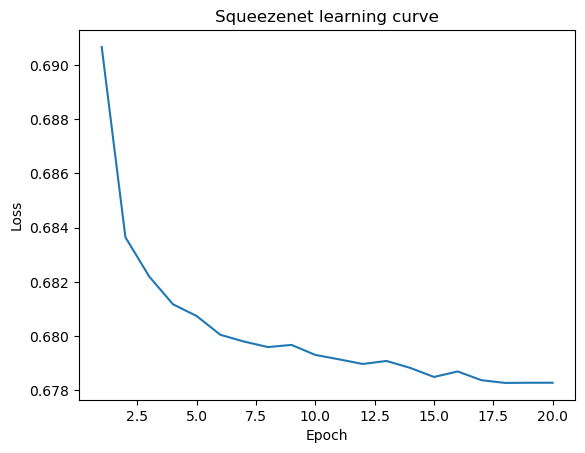

In [14]:
# model = initialize_googlenet_pretrained_model(19)
model = initialize_squeezenet_pretrained_model(19)
if (torch.cuda.is_available()):
	model = model.to('cuda')

# model = AlexNet_Reduced()
# model = CustomCNN(num_classes=19)
loss_fn = nn.BCELoss()

LR = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# Start timing
t0 = time.time()

NUM_EPOCHS = 20
losses = []
for t in range(NUM_EPOCHS):
	print("=====================")
	print(f"Epoch {t+1}")
	print("=====================")
	loss = train_loop(train_dataloader, model, loss_fn, optimizer)
	losses.append(loss)
	validate_loop(val_dataloader, model, threshold=0.5)
print("Done!")

# End timing
t1 = time.time()
print("Model Trained - training time: %i:%i" % ((t1 - t0) // 60, (t1 - t0) % 60))


plt.plot(np.arange(1, NUM_EPOCHS+1), losses)
plt.title('Squeezenet learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Test inference

In [19]:
threshold = 0.5
predicted_labels = []
rows = [['ImageID', 'Labels']]

with torch.no_grad():
	model.eval()
	for idx, (img, id, _) in enumerate(tqdm(test_dataloader, desc="Testing: ")):

		# if idx > 10: # to test on smaller datasets
		#     break
		if (torch.cuda.is_available()):
			img = img.to('cuda')

		output = model(img)
		predicted_label = (output > threshold).float()
		predicted_label_numpy = torch.Tensor.numpy(predicted_label.cpu())[0]
		line = [id[0]]
		label = []
		for i in range(predicted_label_numpy.shape[0]):
			if predicted_label_numpy[i] == 1:
				label.append(str(i+1))
		label = ' '.join(label)
		line.append(label)
		rows.append(line)

with open("submission_image_only_squeezenet.csv", 'w') as file:
	writer = csv.writer(file, delimiter=',', lineterminator='\n')
	writer.writerows(rows)
		

Testing: 100%|██████████| 10000/10000 [00:38<00:00, 259.75it/s]


## NLP with LSTM

### Prepare data

In [ ]:
# Tokenize the sentences and map words to indices
word_to_index = {}
index = 0
for _, _, _, caption in tqdm(DataLoader(train_all_dataset, batch_size = 1)):
	caption = caption[0]
	for word in caption.split():
		if word not in word_to_index:
			word_to_index[word] = index
			index += 1

for _, _, caption in tqdm(DataLoader(test_dataset, batch_size = 1)):
	caption = caption[0]
	for word in caption.split():
		if word not in word_to_index:
			word_to_index[word] = index
			index += 1

In [ ]:
# Convert sentences to sequences of word indices
X_train = []
y_train = []
for _, label, _, caption in tqdm(DataLoader(train_dataset, batch_size = 1)):
	caption = caption[0]
	indices = [word_to_index[word] for word in caption.split()]
	X_train.append(indices)
	y_train.append(label)

# Pad sequences to ensure they have the same length
max_seq_length = max(len(seq) for seq in X_train)
X_train_padded = [seq + [0] * (max_seq_length - len(seq)) for seq in X_train]

# Convert to PyTorch tensors
X_train_tensor = torch.LongTensor(X_train_padded)
y_train_tensor = torch.cat(y_train)

In [ ]:
# Convert sentences to sequences of word indices
X_val = []
y_val = []
for _, label, _, caption in tqdm(val_dataloader):
	caption = caption[0]
	indices = [word_to_index[word] for word in caption.split()]
	X_val.append(indices)
	y_val.append(label)

# Pad sequences to ensure they have the same length
max_seq_length = max(len(seq) for seq in X_val)
X_val_padded = [seq + [0] * (max_seq_length - len(seq)) for seq in X_val]

# Convert to PyTorch tensors
X_val_tensor = torch.LongTensor(X_val_padded)
y_val_tensor = torch.cat(y_val)

In [ ]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(
	dataset=train_data, 
	batch_size=BATCH_SIZE, 
	shuffle=True
)
val_loader = DataLoader(
	dataset=val_data, 
	batch_size=1, 
	shuffle=False
)

### LSTM Classifier

In [ ]:
class LSTMClassifier(nn.Module):
	def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
		super(LSTMClassifier, self).__init__()
		self.embedding = nn.Embedding(vocab_size, embedding_dim)
		self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
		self.fc = nn.Sequential(
			nn.Linear(hidden_dim, output_dim),
			nn.Sigmoid()
		)

	def forward(self, x):
		embedded = self.embedding(x)
		lstm_out, _ = self.lstm(embedded)
		lstm_out = lstm_out[:, -1, :]  # Take the last time step's output
		output = self.fc(lstm_out)
		return output

### Train and Test Loops

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
	# Set the model to training mode - important for batch normalization and dropout layers
	model.train()
	losses = []
	for batch_idx, (captions, labels) in tqdm(enumerate(dataloader)):
		# clear gradients of parameters optimized by the optimizer (because PyTorch accumulates gradients)
		optimizer.zero_grad()
		# Compute prediction and loss
		outputs = model(captions)
		loss = loss_fn(outputs, labels.float())
		losses.append(loss.item())
		# Backpropagation
		loss.backward()
		optimizer.step()

	return np.mean(losses)

def validate_loop(dataloader, model, threshold=0.5):
	model.eval()
	accuracies, f1_scores = [], []
	with torch.no_grad():
		for idx, (caption, label) in tqdm(enumerate(dataloader)):
			output = model(caption)
			predicted_label = (output > threshold).float()

			predicted_label_numpy = torch.Tensor.numpy(predicted_label)[0]
			label_numpy = torch.Tensor.numpy(label)[0]
			accuracies.append(accuracy_score(predicted_label_numpy, label_numpy))
			f1_scores.append(f1_score(predicted_label_numpy, label_numpy, average='macro', zero_division = 0))

	print("Accuracy:", np.mean(accuracies))    
	print("F1 score:", np.mean(f1_scores))

### Training

In [ ]:
vocab_size = len(word_to_index)  # Size of the vocabulary
embedding_dim = 50  # Dimension of word embeddings
hidden_dim = 128  # Dimension of the hidden state in the LSTM
output_dim = 19  # Dimension of the output (binary classification)

# Create an instance of the LSTM classifier
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
print(model)

loss_fn = nn.BCELoss()

LR = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# Start timing
t0 = time.time()

NUM_EPOCHS = 10
losses = []
for t in range(NUM_EPOCHS):
	print("===================")
	print(f"Epoch {t+1}")
	print("===================")
	loss = train_loop(train_loader, model, loss_fn, optimizer)
	losses.append(loss)
	validate_loop(val_loader, model, threshold=0.5)
print("Done!")

# End timing
t1 = time.time()
print("Model Trained - training time: %i:%i" % ((t1 - t0) // 60, (t1 - t0) % 60))

plt.plot(np.arange(1, NUM_EPOCHS+1), losses)
plt.title('LSTM learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Test inference

In [ ]:
# Convert sentences to sequences of word indices
X_test = []
Id = []
for _, img_id, caption in tqdm(test_dataloader):
	caption = caption[0]
	indices = [word_to_index[word] for word in caption.split()]
	X_test.append(indices)
	Id.append(img_id)

# Pad sequences to ensure they have the same length
max_seq_length = max(len(seq) for seq in X_test)
X_test_padded = [seq + [0] * (max_seq_length - len(seq)) for seq in X_test]

In [ ]:
class CustomDataset(Dataset):
	def __init__(self, image_ids, tokenized_captions):
		self.image_ids = image_ids
		self.tokenized_captions = tokenized_captions

	def __len__(self):
		return len(self.image_ids)

	def __getitem__(self, idx):
		image_id = self.image_ids[idx]
		tokenized_caption = self.tokenized_captions[idx]
		return image_id, tokenized_caption

In [ ]:
# Convert to PyTorch tensors
X_test_tensor = torch.LongTensor(X_test_padded)

test_data = CustomDataset(Id, X_test_tensor)

test_loader = DataLoader(
	dataset=test_data, 
	batch_size=1, 
	shuffle=False
)

In [ ]:
threshold = 0.5
predicted_labels = []
rows = [['ImageID', 'Labels']]

with torch.no_grad():
	model.eval()
	for idx, (id, caption) in tqdm(enumerate(test_loader)):

		# if idx > 10: # to test on smaller datasets
		#     break
		output = model(caption)
		predicted_label = (output > threshold).float()
		predicted_label_numpy = torch.Tensor.numpy(predicted_label)[0]
		
		line = [id[0][0]]
		label = []
		for i in range(predicted_label_numpy.shape[0]):
			if predicted_label_numpy[i] == 1:
				label.append(str(i+1))
		label = ' '.join(label)
		line.append(label)
		rows.append(line)

with open("submission_text_only.csv", 'w') as file:
	writer = csv.writer(file, delimiter=',', lineterminator='\n')
	writer.writerows(rows)
	

## CLIP (not good for this task, don't run this section, unless you have time).

CLIP is a model that finds the similarity between an image and a caption/label. Zero-shot prediction would have worked better for our tasks if the labels were words and not numbers.

### Preprocessing

In [ ]:
# Only for CLIP

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

transform = transforms.Compose([
	transforms.ToTensor(),
])

# The train/val dataset available with labels
train_all_dataset = MultiLabelDataset(csv_file = TRAIN_CSV,
							image_dir = IMAGES_DIR,
							transform = transform,
							target_transform = transforms.Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
							has_labels = True
							)

# Need to further split it up
train_dataset, val_dataset = random_split(train_all_dataset,
										  [int(round(TRAIN_VAL_PROP * len(train_all_dataset))), int(round((1 - TRAIN_VAL_PROP) * len(train_all_dataset)))],
										  generator=torch.Generator().manual_seed(SEED)) # Setting seed to ensure consistency

# The final test dataset with no labels
test_dataset = MultiLabelDataset(csv_file = TEST_CSV,
								 image_dir = IMAGES_DIR,
								transform = transform,
								 has_labels = False)

train_all_dataloader = DataLoader(train_all_dataset, batch_size = 1, shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Train and Test Loops

In [ ]:
text = [str(i) for i in range(19)]

def train_loop(dataloader, model, loss_fn, optimizer):
	# Set the model to training mode - important for batch normalization and dropout layers
	model.train()
	losses = []
	for batch_idx, (img, labels, _, _) in tqdm(enumerate(dataloader)):

		if batch_idx > 10: # to test on smaller datasets
			break

		# clear gradients of parameters optimized by the optimizer (because PyTorch accumulates gradients)
		optimizer.zero_grad()
		
		inputs = processor(text=text, images=img, return_tensors="pt", padding=True)

		# Compute prediction and loss
		output = model(**inputs)
		logits_per_image = output.logits_per_image  # this is the image-text similarity score
		predicted_labels = logits_per_image.sigmoid()  # we can take the sigmoid to get the labels
		
		loss = loss_fn(predicted_labels, labels.float())
		losses.append(loss.item())
		# Backpropagation
		loss.backward()
		optimizer.step()

		# if batch_idx % 10 == 0:
		#     print(loss.item())
		
	return np.mean(losses)
		

def validate_loop(dataloader, model, threshold=0.5):
	model.eval()
	accuracies, f1_scores = [], []
	with torch.no_grad():
		for idx, (img, label, _, _) in tqdm(enumerate(dataloader)):

			if idx > 10: # to test on smaller datasets
				break
			
			inputs = processor(text=text, images=img, return_tensors="pt", padding=True)

			output = model(**inputs)
			logits_per_image = output.logits_per_image  # this is the image-text similarity score
			predicted_label = logits_per_image.sigmoid()  # we can take the sigmoid to get the labels
			predicted_label = (predicted_label > threshold).float()[0]
			predicted_label_numpy = torch.Tensor.numpy(predicted_label)
			label_numpy = torch.Tensor.numpy(label)[0]
			accuracies.append(accuracy_score(predicted_label_numpy, label_numpy))
			f1_scores.append(f1_score(predicted_label_numpy, label_numpy, average='macro', zero_division = 0))

	print("Accuracy:", np.mean(accuracies))    
	print("F1 score:", np.mean(f1_scores))

### Training

In [ ]:
loss_fn = nn.BCELoss()

LR = 5
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# Start timing
t0 = time.time()

NUM_EPOCHS = 5
losses = []
for t in range(NUM_EPOCHS):
	print("=====================")
	print(f"Epoch {t+1}")
	print("=====================")
	loss = train_loop(train_dataloader, model, loss_fn, optimizer)
	losses.append(loss)
	validate_loop(val_dataloader, model, threshold=0.5)
print("Done!")

# End timing
t1 = time.time()
print("Model Trained - training time: %i:%i" % ((t1 - t0) // 60, (t1 - t0) % 60))


plt.plot(np.arange(1, NUM_EPOCHS+1), losses)
plt.title('CLIP learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Test inference

In [ ]:
threshold = 0.5
predicted_labels = []
rows = [['ImageID', 'Labels']]

text = [str(i) for i in range(19)]

# inference
with torch.no_grad():
	model.eval()
	for img, id, _ in tqdm(test_dataloader):

		inputs = processor(text=text, images=img, return_tensors="pt", padding=True)

		# if idx > 10: # to test on smaller datasets
		#     break
		output = model(**inputs)
		logits_per_image = output.logits_per_image  # this is the image-text similarity score
		predicted_label = logits_per_image.sigmoid()  # we can take the sigmoid to get the labels
		predicted_label = (predicted_label > threshold).float()[0]
		line = [id[0]]
		label = []
		for i in range(predicted_label.shape[0]):
			if predicted_label[i] == 1:
				label.append(str(i+1))
		label = ' '.join(label)
		line.append(label)
		rows.append(line)

# writing in file for submission
with open("submission_image_only_clip.csv", 'w') as file:
	writer = csv.writer(file, delimiter=',', lineterminator='\n')
	writer.writerows(rows)

## Vision Transformer

### Initialization of model

In [ ]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

def initialize_vit_pretrained_model(num_labels):
	model = ViTForImageClassification.from_pretrained(model_name_or_path, num_labels=num_labels)
	return model

def vit_processor(image):
	return processor(image, return_tensors='pt')['pixel_values'][0]

### Image preprocessing

In [ ]:
# Concluded 19 labels - one-hot encoded. Leaving label 12 in there as it'll just have zeros for this index
NUM_LABELS = 19
BATCH_SIZE = 2
TRAIN_VAL_PROP = 0.8
SEED = 5329

transform = vit_processor

# The train/val dataset available with labels
train_all_dataset = MultiLabelDataset(csv_file = TRAIN_CSV,
							image_dir = IMAGES_DIR,
							transform = transform,
							target_transform = transforms.Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
							has_labels = True
							)

# Need to further split it up
train_dataset, val_dataset = random_split(train_all_dataset,
										  [int(round(TRAIN_VAL_PROP * len(train_all_dataset))), int(round((1 - TRAIN_VAL_PROP) * len(train_all_dataset)))],
										  generator=torch.Generator().manual_seed(SEED)) # Setting seed to ensure consistency

# The final test dataset with no labels
test_dataset = MultiLabelDataset(csv_file = TEST_CSV,
								 image_dir = IMAGES_DIR,
								transform = transform,
								 has_labels = False)

train_all_dataloader = DataLoader(train_all_dataset, batch_size = BATCH_SIZE, shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Train and Test Loops

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
	# Set the model to training mode - important for batch normalization and dropout layers
	model.train()
	losses = []
	for batch_idx, (images, labels, _, _) in tqdm(enumerate(dataloader)):

		# if batch_idx > 10: # to test on smaller datasets
		#     break

		# clear gradients of parameters optimized by the optimizer (because PyTorch accumulates gradients)
		optimizer.zero_grad()
		# Compute prediction and loss
		outputs = model(images)
		loss = loss_fn(outputs.logits.sigmoid(), labels.float())
		losses.append(loss.item())
		# Backpropagation
		loss.backward()
		optimizer.step()
		# if batch_idx % 10 == 0:
		#     print(loss.item())
		
	return np.mean(losses)
		

def validate_loop(dataloader, model, threshold=0.5):
	model.eval()
	accuracies, f1_scores = [], []
	with torch.no_grad():
		for idx, (image, label, _, _) in tqdm(enumerate(dataloader)):

			# if idx > 10: # to test on smaller datasets
			#     break
			
			output = model(image)
			predicted_label = (output.logits.sigmoid() > threshold).float()
			predicted_label_numpy = torch.Tensor.numpy(predicted_label)[0]
			label_numpy = torch.Tensor.numpy(label)[0]
			accuracies.append(accuracy_score(predicted_label_numpy, label_numpy))
			f1_scores.append(f1_score(predicted_label_numpy, label_numpy, average='macro', zero_division = 0))

	print("Accuracy:", np.mean(accuracies))    
	print("F1 score:", np.mean(f1_scores))

### Training

In [ ]:
model = initialize_vit_pretrained_model(19)
loss_fn = nn.BCELoss()

LR = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# Start timing
t0 = time.time()

NUM_EPOCHS = 10
losses = []
for t in range(NUM_EPOCHS):
	print("=====================")
	print(f"Epoch {t+1}")
	print("=====================")
	loss = train_loop(train_dataloader, model, loss_fn, optimizer)
	losses.append(loss)
	# validate_loop(val_dataloader, model, threshold=0.5)
print("Done!")

# End timing
t1 = time.time()
print("Model Trained - training time: %i:%i" % ((t1 - t0) // 60, (t1 - t0) % 60))


plt.plot(np.arange(1, NUM_EPOCHS+1), losses)
plt.title('Vision Transformer learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Test inference

In [ ]:
threshold = 0.5
predicted_labels = []
rows = [['ImageID', 'Labels']]

with torch.no_grad():
	model.eval()
	for idx, (img, id, _) in tqdm(enumerate(test_dataloader)):

		# if idx > 150: # to test on smaller datasets
		#     break
		
		output = model(img)
		predicted_label = (output.logits.sigmoid() > threshold).float()
		predicted_label_numpy = torch.Tensor.numpy(predicted_label)[0]
		line = [id[0]]
		label = []
		for i in range(predicted_label_numpy.shape[0]):
			if predicted_label_numpy[i] == 1:
				label.append(str(i+1))
		label = ' '.join(label)
		line.append(label)
		rows.append(line)

with open("submission_image_only_vit.csv", 'w') as file:
	writer = csv.writer(file, delimiter=',', lineterminator='\n')
	writer.writerows(rows)